In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


In [2]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

def dlt(originals, correspondence):  ## numpy arrays of the same size
    points_number = np.shape(originals)[0];
    ## o =  orignals
    ## c = correspondence
    o_centroid = np.mean(originals, axis=0)
    c_centroid = np.mean(correspondence, axis=0)
    
    o_centered = originals - np.tile(o_centroid, (points_number,1))
    c_centered = correspondence - np.tile(c_centroid, (points_number,1))
    
    o_norms = np.linalg.norm(o_centered, axis=1)
    c_norms = np.linalg.norm(c_centered, axis=1)                                           
    
    o_distance = np.mean(o_norms)
    c_distance = np.mean(c_norms)
                                          
    o_scale = np.sqrt(2)/o_distance
    c_scale = np.sqrt(2)/c_distance
    
    H_sim_prim = np.array([[c_scale,0      ,-c_centroid[0]*c_scale],
                          [0      ,c_scale,-c_centroid[1]*c_scale],
                          [0      ,0      ,1]])

    
    H_sim = np.array([[o_scale,0      ,-o_centroid[0]*o_scale],
                      [0      ,o_scale,-o_centroid[1]*o_scale],
                      [0      ,0      ,1]])
    
    o_homologous = np.transpose(H_sim @ np.transpose(originals))
    c_homologous = np.transpose(H_sim_prim @ np.transpose(correspondence))

    H_sim_prim = np.linalg.inv(H_sim_prim)
                                             
    A = np.zeros((points_number*2,9))

    zerot = np.array([0,0,0])

    for i in range(0, points_number):
        xt = o_homologous[i, :]
        
        wixt = c_homologous[i,2] * xt
        yixt = c_homologous[i,1] * xt
        xixt = c_homologous[i,0] * xt
        A[2*i,:] = np.concatenate((zerot, -wixt, yixt))
        A[2*i + 1,:] = np.concatenate((wixt, zerot, -xixt))
    (u,d,v) = np.linalg.svd(A)
    
    H = np.reshape(v[-1, :], (3,3))
    H = np.dot(H, H_sim)
    H = np.dot(H_sim_prim, H)
    
    return H



def transf_dlt(H, img):
    H_inv = np.linalg.inv(H)
    img_transf = np.zeros(img.shape)
    img_hist = np.zeros(img.shape)
    vect_ant = np.array([-1,-1,-1])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            vect = np.array([x,y,1])
            vect = H_inv @ vect
            vect = vect/vect[2]
                
            if (int(vect[0])< img.shape[0] and  int(vect[0])>= 0) and (int(vect[1])< img.shape[1] and  int(vect[1])>= 0):
                img_transf[x, y, :] = img[int(vect[0]),int(vect[1]),:].astype(np.uint8)
    
    return img_transf

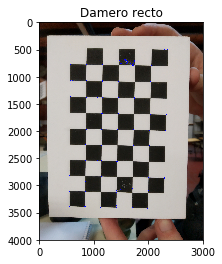

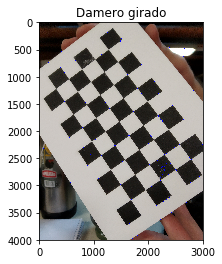

True

In [3]:
damero = cv2.imread('../../dameros/IMG_20181030_174017.jpg')
damero_twist = cv2.imread('../../dameros/IMG_20181030_174022.jpg')
estrella = cv2.imread('estrella.png')
estrella_r = cv2.imread('estrella_r.png')

gray = cv2.cvtColor(damero,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray,100,0.01,10)
corners = np.int0(corners)

cant = 0
for i in corners:
    x,y = i.ravel()
    if(y >= 500 and y <= 3500 and x >= 500 and x <= 2500):
        cv2.circle(damero,(x,y),10,255,-1)
        cant += 1

plt.title("Damero recto")
plt.imshow(damero[:,:,::-1]),plt.show()

cv2.imwrite('damero.png', damero)

gray_twist = cv2.cvtColor(damero_twist,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray_twist,100,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(damero_twist,(x,y),10,255,-1)

plt.title("Damero girado")
plt.imshow(damero_twist[:,:,::-1]),plt.show()
cv2.imwrite('damero_twist.png', damero_twist)

In [4]:
rect_puntos = np.array([[2358, 510,1],[872, 482,1],[560, 3377,1], [1993, 3137,1]])
gir_puntos = np.array([[1353, 113,1],[169, 1001,1],[1600, 3727,1], [2784, 2521,1]])

H = dlt(gir_puntos, rect_puntos)
H_gir = dlt(rect_puntos, gir_puntos)

In [6]:
recto_a_girado = transf_dlt(H, damero)
recto_a_girado = recto_a_girado.astype(np.uint8)

girado_a_recto = transf_dlt(H_gir, damero_twist)
girado_a_recto = girado_a_recto.astype(np.uint8)

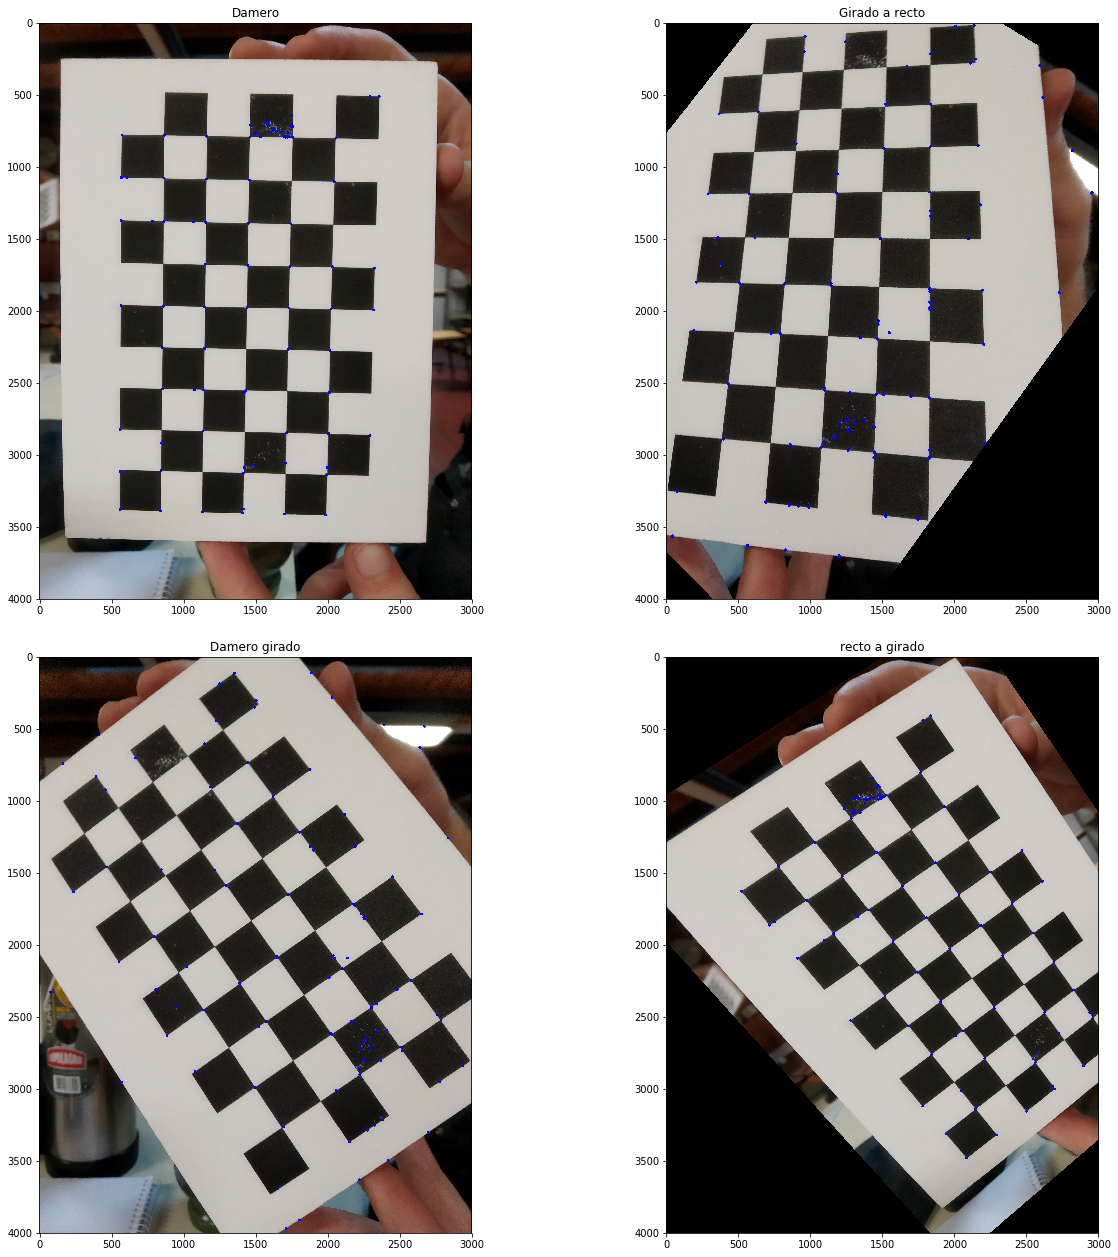

In [7]:
plt.figure(1, figsize=(20,20))

# linear
plt.subplot(221)
plt.title("Damero")
plt.imshow(damero[:,:,::-1])

plt.subplot(222)
plt.plot(x, y)
plt.title('Girado a recto')
plt.imshow(girado_a_recto[:,:,::-1])

plt.subplot(223)
plt.title("Damero girado")
plt.imshow(damero_twist[:,:,::-1])

plt.subplot(224)
plt.title("recto a girado")
plt.imshow(recto_a_girado[:,:,::-1])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.05)
plt.show()

Se eligieron cuatro puntos a mano de los encontrados con el detector de esquinas de harris, parece ser que la parte proyectiva de la matriz no esta siendo calculada. esto puede ser causado por los puntos que agarramos.

In [8]:
print(H)
print("--------------------------")
print(H_gir)

[[ 0.469 -0.287  666.396]
 [ 0.377  0.479 -289.762]
 [ 0.000  0.000  0.500]]
--------------------------
[[ 0.481  0.309 -462.514]
 [-0.384  0.425  758.882]
 [-0.000 -0.000  0.653]]


In [3]:
damero = cv2.imread('../../dameros/IMG_20181030_174017.jpg')
damero_twist = cv2.imread('../../dameros/IMG_20181030_174022.jpg')
estrella = cv2.imread('estrella.png')
estrella_r = cv2.imread('estrella_r.png')
gray = cv2.cvtColor(damero,cv2.COLOR_BGR2GRAY)
gray_twist = cv2.cvtColor(damero_twist,cv2.COLOR_BGR2GRAY)

gray_s = cv2.cvtColor(estrella,cv2.COLOR_BGR2GRAY)
gray_twist_s = cv2.cvtColor(estrella_r,cv2.COLOR_BGR2GRAY)


In [11]:
print(gray.shape)

(4000, 3000)


In [98]:
sift = cv2.xfeatures2d.SIFT_create()

(kps, desc) = sift.detectAndCompute(gray, None)

(kps_twist, desc_twist) = sift.detectAndCompute(gray_twist, None)

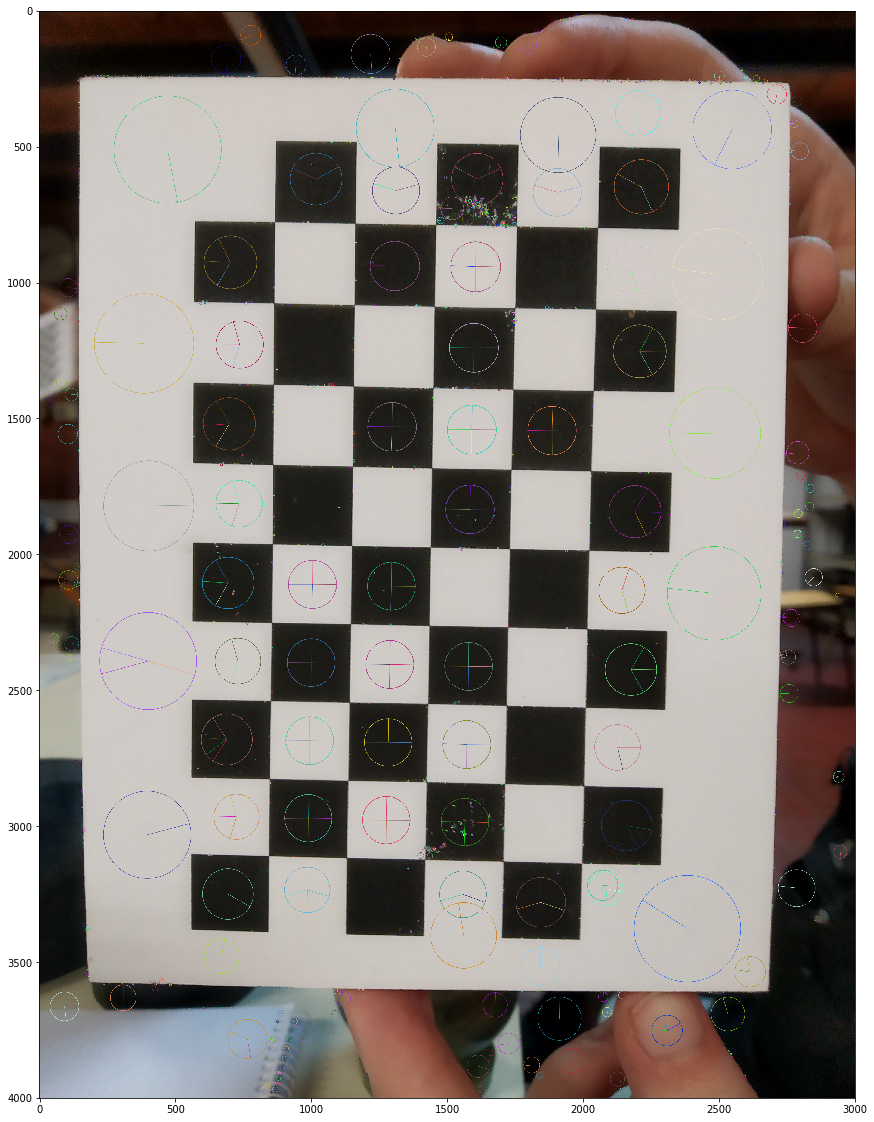

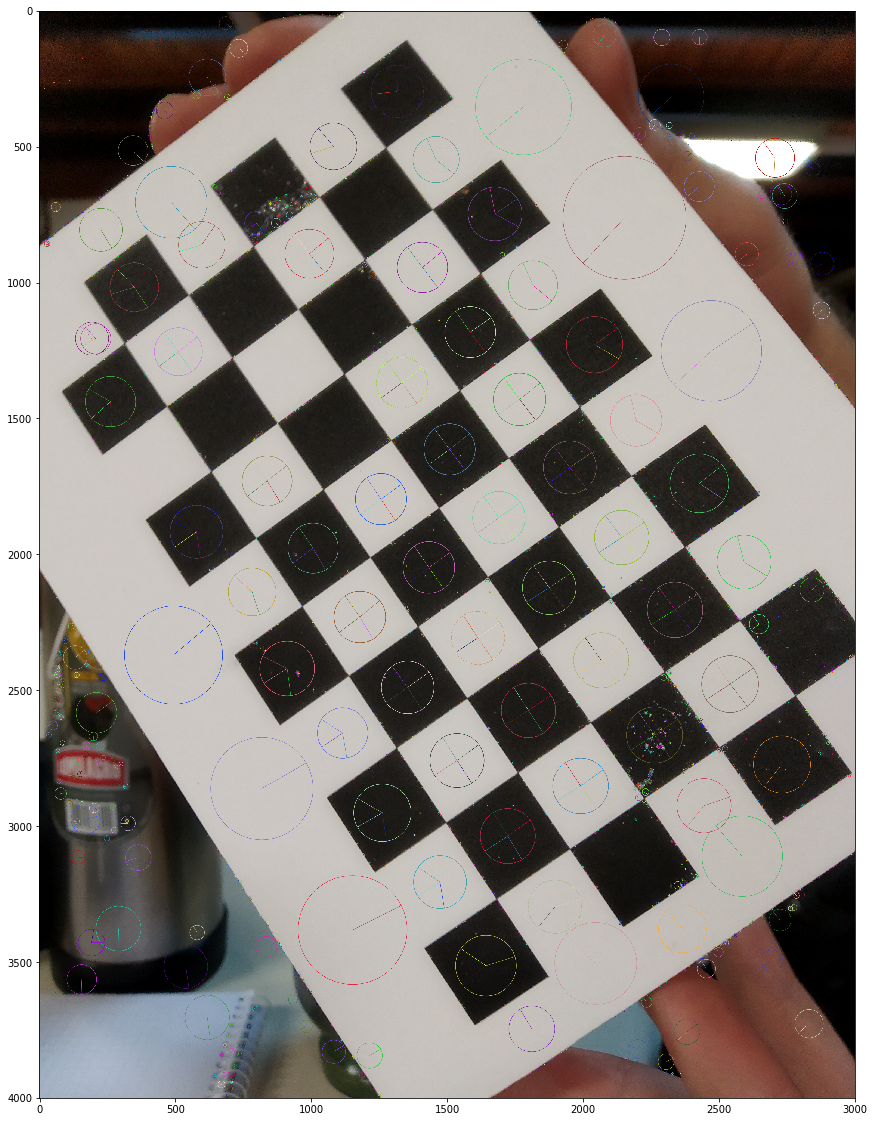

(<matplotlib.image.AxesImage at 0x7fc3a3c9d9b0>, None)

In [30]:
aux = damero
aux2 = damero
plt.figure(4, figsize=(20,20))
cv2.drawKeypoints(damero, kps, aux, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(aux[:,:,::-1]),plt.show()
plt.figure(3,figsize=(20,20))
cv2.drawKeypoints(damero_twist, kps_twist, aux2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(aux2[:,:,::-1]),plt.show()

In [82]:
orb = cv2.ORB_create()
# find the keypoints with ORB
#kps = orb.detect(gray,None)
# compute the descriptors with ORB
o_kps, o_desc = orb.detectAndCompute(gray, None)
#kps_twist = orb.detect(gray_twist, None)
o_kps_twist, o_desc_twist = orb.detectAndCompute(gray_twist, None)

In [5]:
def get_keypoints_desc(gray, gray_twist):
    orb = cv2.ORB_create()
    o_kps, o_desc = orb.detectAndCompute(gray, None)

    o_kps_twist, o_desc_twist = orb.detectAndCompute(gray_twist, None)
    
    return (o_kps, o_desc, o_kps_twist, o_desc_twist)

In [9]:
def get_matches(desc, desc_twist):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=False)

    matches = bf.knnMatch(desc,desc_twist, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if n.distance*1.05 > m.distance and m.distance < 0.95*n.distance:
            good.append([m])
    
    return (matches, good)

bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

# Match descriptors.
matches_orb = bf.match(desc,desc_twist)

# Sort them in the order of their distance.
matches_orb = sorted(matches_orb, key = lambda x:x.distance)
y_max, x_max = (0,0)
for kp in kps:
    if kp.pt[0]>x_max:
        x_max = kp.pt[0]
    if kp.pt[1] > y_max:
        y_max = kp.pt[1]

print(x_max, y_max)

In [83]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=False)

k_matches = bf.knnMatch(o_desc,o_desc_twist, k=2)

# Apply ratio test
good = []
for m,n in k_matches:
    if n.distance*1.05 > m.distance and m.distance < 0.95*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
#img3 = cv2.drawMatchesKnn(damero,kps,damero_twist,kps_twist,good,flags=2)

#plt.imshow(img3),plt.show()

#Match descriptors.
#matches = bf.match(desc,desc_twist)

# Sort them in the order of their distance.
#matches = sorted(matches, key = lambda x:x.distance)

#Draw first 10 matches.
#aux = matches[0]
#cv2.drawMatches(damero,kps,damero_twist,kps_twist,matches[:50], outImg = img3, flags=0)


#plt.imshow(img3),plt.show()

In [29]:
def show_matches(img1, img2, kps, kps2, matches, good, cant_show):
    aux = np.concatenate((img1,img2), axis=1)
    x_offset = img1.shape[1]
    print(img1.shape)
    plt.imshow(aux[:,:,::-1])
    for match, match2 in matches[:cant_show]:
        x, y = kps[match.queryIdx].pt
        xt, yt = kps2[match.trainIdx].pt
        plt.plot([x,xt+x_offset], [y,yt], 'ro-', linewidth=0.8, markersize=1)
        x, y = kps[match2.queryIdx].pt
        xt, yt = kps2[match2.trainIdx].pt
        #plt.plot([x,xt+3000], [y,yt], 'bo', linewidth=0.8, markersize=1)
    plt.show()
    
    plt.imshow(aux[:,:,::-1])
    for match in matches[:cant_show]:
        x, y = kps[match[0].queryIdx].pt
        xt, yt = kps2[match[0].trainIdx].pt
        plt.plot([x,xt+x_offset], [y,yt], 'ro', linewidth=0.8, markersize=1)
    plt.show()
    
    
    plt.imshow(aux[:,:,::-1])
    for match in good[:cant_show]:
        x, y = kps[match[0].queryIdx].pt
        xt, yt = kps2[match[0].trainIdx].pt
        plt.plot([x,xt+x_offset], [y,yt], 'ro-', linewidth=0.8, markersize=1)
        x, y = kps[match2.queryIdx].pt
        xt, yt = kps2[match2.trainIdx].pt
        #plt.plot([x,xt+3000], [y,yt], 'bo', linewidth=0.8, markersize=1)
    plt.show()
    
    plt.imshow(aux[:,:,::-1])
    for match in good[:cant_show]:
        x, y = kps[match[0].queryIdx].pt
        xt, yt = kps2[match[0].trainIdx].pt
        plt.plot([x,xt+x_offset], [y,yt], 'ro', linewidth=0.8, markersize=1)
    plt.show()
    

(400, 640)
(400, 640, 3)


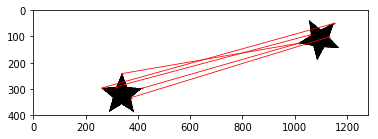

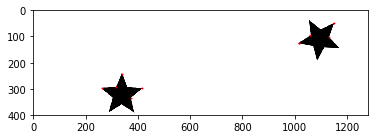

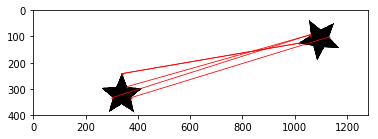

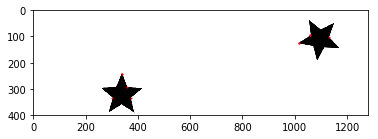

In [31]:
print(gray_s.shape)
kps, desc, kps2, desc2 = get_keypoints_desc(gray_s, gray_twist_s)
matches, good = get_matches(desc, desc2)
show_matches(estrella, estrella_r, kps, kps2, matches, good, 5)

(4000, 3000, 3) (4000, 3000, 3)
(4000, 6000, 3)
500


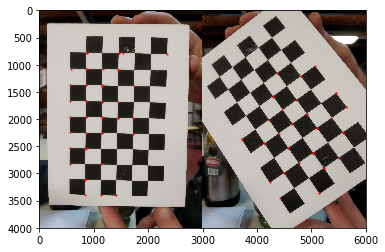

In [85]:
print(damero.shape, damero_twist.shape)
aux = np.concatenate((damero, damero_twist), axis = 1)
print(aux.shape)
print(len(matches))
plt.imshow(aux[:,:,::-1])


for match, match2 in k_matches[:50]:
    x, y = o_kps[match.queryIdx].pt
    xt, yt = o_kps_twist[match.trainIdx].pt
    #xi, yi = match.imgIdx.pt
    plt.plot([x,xt+3000], [y,yt], 'ro', linewidth=0.8, markersize=1)
    x, y = o_kps[match2.queryIdx].pt
    xt, yt = o_kps_twist[match2.trainIdx].pt
    #plt.plot([x,xt+3000], [y,yt], 'bo', linewidth=0.8, markersize=1)
plt.show()

Arriba mostramos las primeras 50 correspondencias, no parece ser que este andando bien knn, abajo estan 10 de las mejores donde nos aseguramos que los vecinos esten cerca.

(2349.0, 806.0) 0
(862.0, 1080.0) 0
(562.0, 2820.0) 0
(1462.0, 792.0) 0
(854.0, 2542.0) 0
(567.0, 1961.0) 0
(1135.0, 2831.0) 0
(1158.0, 1381.0) 0
(869.0, 777.0) 0
(571.0, 1072.0) 0


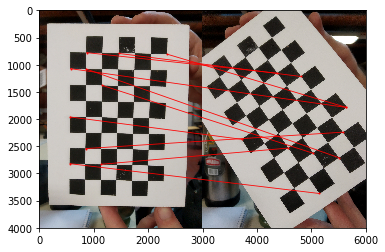

In [93]:
plt.imshow(aux[:,:,::-1])
for match in good[:10]:
    x, y = o_kps[match[0].queryIdx].pt
    xt, yt = o_kps_twist[match[0].trainIdx].pt
    plt.plot([x,xt+3000], [y,yt], 'ro-', linewidth=0.8, markersize=1)
plt.show()

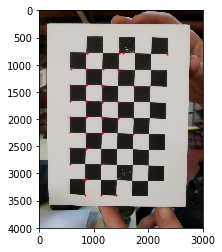

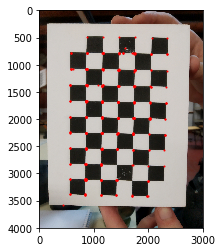

In [77]:
plt.imshow(damero[:,:,::-1])
for key, key2 in k_matches[:50]:
    x, y = o_kps[key.queryIdx].pt
    plt.plot(x, y, 'ro', markersize=1)
plt.show()

plt.imshow(damero[:,:,::-1])
for key in o_kps:
    x, y = key.pt
    plt.plot(x, y, 'ro', markersize=1)
plt.show()

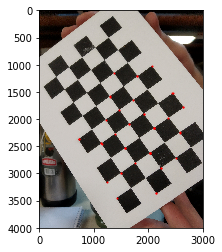

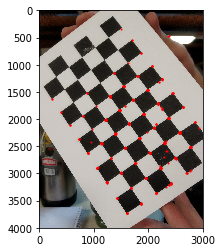

In [76]:
plt.imshow(damero_twist[:,:,::-1])
for key, key2 in k_matches[:50]:
    x, y = o_kps_twist[key.trainIdx].pt
    plt.plot(x, y, 'ro', markersize=1)
plt.show()


plt.imshow(damero_twist[:,:,::-1])
for key in o_kps_twist:
    x, y = key.pt
    plt.plot(x, y, 'ro', markersize=1)
plt.show()

In [ ]:
alphas = {0.9: 4.605, 0.95:5.991, 0.99:9.210}
desvios = [1, 0.5, 1.5]
t_estandar = alphas[0.95]*desvios[1]
sample_size = 2
#points is a np.ndarray

def create_homografic(originals, correspondences):
    ab_ind = np.random.choice(originals.shape[0], size = 2, replace = False) 
    a_ind = ab_ind[0]
    b_ind = ab_ind[1]
    colineal = True
    a = originals[a_ind,:]
    b = originals[b_ind,:]
    ab = np.cross(a,b)
    c = a
    c_ind = a_ind
    while np.cross(ab, c) == 0:
        c_ind = np.random.choice(originals.shape[0])
        c = originals[c_ind, :]
    ac = np.cross(a,c)
    bc = np.cross(b,c)
    d = a
    d_ind = a_ind
    while np.cross(ab, d) == 0 or np.cross(bc, d) == 0 or np.cross(ac, d) == 0:
        d_ind = np.random.choice(originals.shape[0])
        d = originals[d_ind, :]
        
    return dlt(originals[[a_ind, b_ind, c_ind, d_ind]], correspondences[[a_ind, b_ind, c_ind, d_ind]])

    
    
def d_trans(H, original, correspondence):
    inverse = np.linalg.inv(H)
    d = np.linalg.norm(original, inverse @ correspondence)**2
    d += np.linalg.norm(correspondence, H @ original)
    
    return d

def ransac(originals, correspondences):
    t = 5.991 #desvio es 1
    n = 11 #outliers = 40%
    stoping_size = len(point)*0.6
    sample_size = 2
    H = np.array([])
    support = []
    points_idx = list(range(points.shape()[0]))
    
    for i in range(n):
        H_aux = create_homografic(originals, correspondences)
        cant = 0
        suport_aux = []
        for j in range(points.shape()[0]):
            distance = d_trans(H_aux, originals[j,:], correspondencess[j,:])
            if distance <= t:
                support_aux.append(j)
        if len(support) < len(support_aux):
                support = support_aux
                H = H_aux
        if cant >= stoping_size:
            break

    H_big = dlt(originals[support], correspondences[support])
    
    return H_big

In [ ]:
puntos_recta = np.array([[339,241,1],[416,298,1], [385,388, 1], [291,387,1]])#, [262,297,1]])
puntos_rotadas = np.array([[415,40,1],[509,50,1],[528,143,1],[446,189,1]])#,[365,126,1]])

H = dlt(puntos_rotadas, puntos_recta)
H_gir = dlt(puntos_recta, puntos_rotadas)

In [ ]:
girada_a_recta = transf_dlt(H_gir, estrella_r)
girada_a_recta = girada_a_recta.astype(np.uint8)

recta_a_girada = transf_dlt(H, estrella)
recta_a_girada = recta_a_girada.astype(np.uint8)


In [ ]:
plt.figure(1, figsize=(20,20))

# linear
plt.subplot(221)
plt.title("Estrella")
plt.imshow(estrella)

plt.subplot(222)
plt.plot(x, y)
plt.title('Girada a recta')
plt.imshow(girada_a_recta[:,:,::-1])

plt.subplot(223)
plt.title("Estrella girada")
plt.imshow(estrella_r)

plt.subplot(224)
plt.title("recta a girada")
plt.imshow(recta_a_girada[:,:,::-1])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.05)
plt.show()